# 네이버 쇼핑 리뷰 감성 분류하기

1. Okt 설치

형태소 분석기 Okt를 이용하여 실습 진행

In [ ]:
#install okt, komoran kkma
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 KB 21.9 MB/s eta 0:00:00


# 데이터에 대한 이해와 전처리

In [ ]:
from konlpy.tag import Kkma, Okt

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. 데이터 로드하기

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [ ]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## 2. 훈련 데이터와 테스트 데이터 분리하기

데이터가 별도의 레이블을 갖고있지 않으므로 평점 4, 5인 리뷰에는 1, 평점이 1, 2인 리뷰에는 레이블 0을 부여

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


(rating, reviews, label)열의 중복을 제외한 샘플 개수를 출력

In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

중복 제거

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열 에서 중복인 내용이 있다면 중복 제거
print(' 총 샘 플 의 수 :',len(total_data))

 총 샘 플 의 수 : 199908


결측치 확인

In [ ]:
print(total_data.isnull().values.any())

False


훈련 데이터와 테스트 데이터를 3:1 비율로 분리

In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


## 3. 레이블 분포 확인

<Axes: >

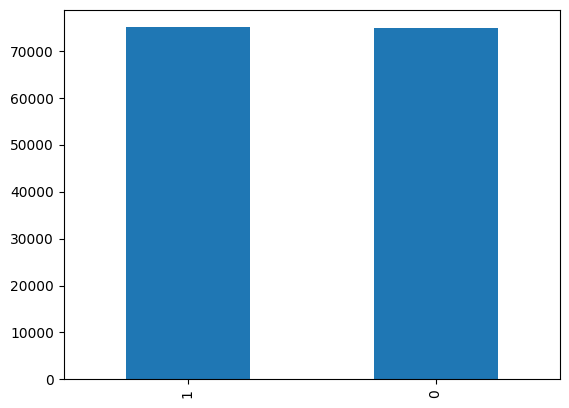

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


두 레이블 모두 약 50:50 비율을 가지고 있음

## 4. 데이터 정제하기

정규 표현식을 이용하여 한글을 제외하고 모두를 제거 후 빈 샘플이 있는지 확인

In [ ]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-12-e6a71d3edfa3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


ratings    0
reviews    0
label      0
dtype: int64


테스트 데이터에도 같은 과정을 적용

In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


<ipython-input-13-95386e1de338>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


## 5. 토큰화

In [ ]:
okt = Okt()
print(okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이라고', '차라리', '내', '가', '만드는', '게', '나을', '뻔']


불용어 정의, 제거

In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

긍, 부정 리뷰에 자주 등장하는 단어, 빈도 확인

In [ ]:
from collections import Counter

negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_word_count = Counter(negative_words) # 파이썬의 Counter 모듈을 이용하면 단어의 모든 빈도를 쉽게 계산할 수 있습니다.
print(negative_word_count)

negative_word_count.most_common(20)

print(negative_word_count.most_common(20))

positive_word_count = Counter(positive_words) # 파이썬의 Counter 모듈을 이용하면 단어의 모든 빈도를 쉽게 계산할 수 있습니다.
print(positive_word_count)

positive_word_count.most_common(20)

print(positive_word_count.most_common(20))

Counter({'너무': 13039, '요': 11784, '안': 11676, '배송': 9171, '그냥': 8518, '잘': 7817, '로': 5777, '했는데': 5692, '별로': 5549, '못': 5174, '제품': 5071, '으로': 4999, '생각': 4927, '좀': 4878, '사용': 4846, '하고': 4769, 'ㅠㅠ': 4760, '구매': 4634, '보다': 4617, '맛': 4017, '만': 3961, '개': 3896, 'ㅠ': 3815, '입니다': 3803, '많이': 3754, '가격': 3682, '주문': 3622, '재구매': 3417, '부분': 3323, '해서': 3315, '같아요': 3289, '에서': 3215, '서': 3202, '반품': 3143, '때': 3104, '냄새': 3054, '사이즈': 3051, '더': 3046, '상품': 2973, '것': 2809, '다른': 2738, '포장': 2715, 'ㅜㅜ': 2682, '거': 2565, '제': 2518, '나': 2425, '합니다': 2423, '두': 2371, '하나': 2370, '샀는데': 2239, '인데': 2229, '저': 2151, '정도': 2050, '진짜': 2015, '정말': 1898, '교환': 1885, '일': 1799, '느낌': 1767, '그': 1759, '실망': 1721, '이라': 1719, 'ㅡㅡ': 1706, '다시': 1682, '돈': 1660, '면': 1646, '사진': 1636, '상태': 1605, '이네': 1587, '중': 1566, '한번': 1559, '조금': 1549, '엄청': 1544, 'ㅜ': 1536, '넘': 1522, '불량': 1505, '완전': 1495, '박스': 1494, '할': 1479, '에요': 1475, '걸': 1466, '해': 1457, '왔네요': 1453, '귀찮아서': 1450, '왔어요': 1448

 긍정 리뷰의 평균 길이 : 10.768613440337008
 부정 리뷰의 평균 길이 : 14.101804639739449


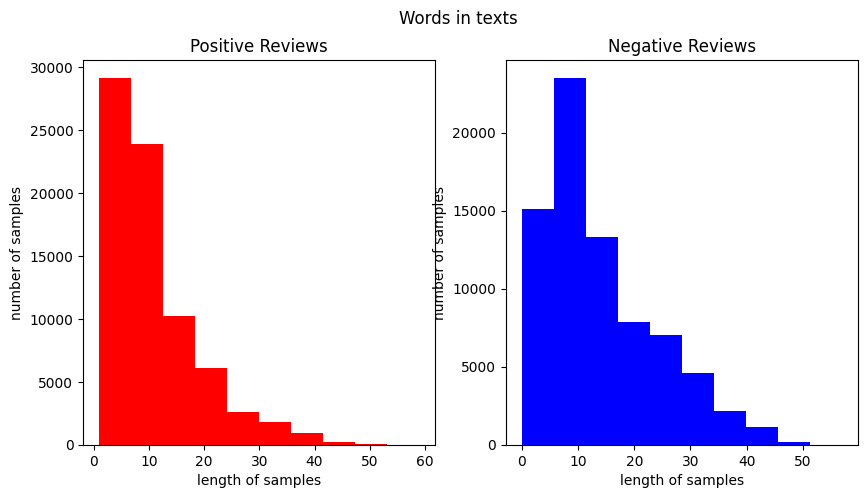

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print(' 긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))


ax2.hist(text_len, color='blue') 
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples') 
ax2.set_ylabel('number of samples') 
print(' 부정 리뷰의 평균 길이 :', np.mean(text_len)) 
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

## 7. 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 94361
등장 빈도가 1번 이하인 희귀 단어의 수: 52344
단어 집합에서 희귀 단어의 비율: 55.47207002893144
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.807755335212537


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 42019


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[33, 2263, 274, 1, 294, 174, 105, 78, 328, 5, 9212, 790, 5, 34, 25, 1637, 1036, 391, 92, 6], [2867, 1494, 4132, 3159, 3194, 260, 1, 1], [14, 139, 6114, 318, 2720, 504, 2, 7, 30070, 946, 52, 29, 100, 2995, 170, 504, 100, 2, 13635, 7396, 4010, 5, 69, 18012]]


In [ ]:
print(X_test[:3])

[[3, 6886, 778, 2095, 151, 2214], [260, 7279, 25, 5281], [4, 714, 16, 96, 64, 32, 20, 496, 131, 1, 67, 2837, 2, 117]]


리뷰의 최대 길이 : 59
리뷰의 평균 길이 : 12.43415304373345


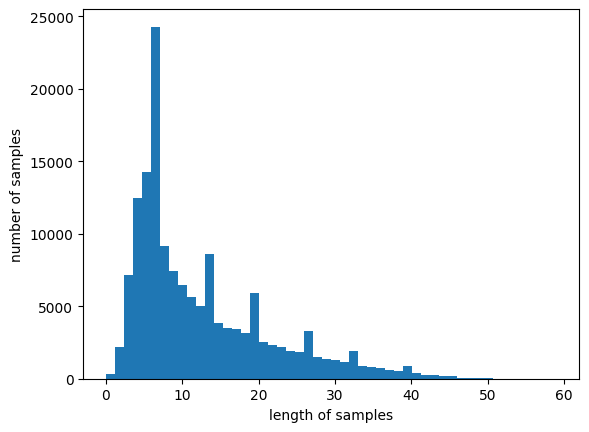

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# GRU를 이용한 분류

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2974 - acc: 0.8845
Epoch 1: val_acc improved from -inf to 0.90796, saving model to best_model.h5
2000/2000 [==============================] - 134s 58ms/step - loss: 0.2974 - acc: 0.8845 - val_loss: 0.2499 - val_acc: 0.9080
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2302 - acc: 0.9170
Epoch 2: val_acc improved from 0.90796 to 0.91390, saving model to best_model.h5
2000/2000 [==============================] - 25s 12ms/step - loss: 0.2302 - acc: 0.9170 - val_loss: 0.2361 - val_acc: 0.9139
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2055 - acc: 0.9282
Epoch 3: val_acc improved from 0.91390 to 0.91483, saving model to best_model.h5
2000/2000 [==============================] - 18s 9ms/step - loss: 0.2055 - acc: 0.9282 - val_loss: 0.2414 - val_acc: 0.9148
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1866 - acc: 0.9370
Epoch 4: val_

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

1/1 [==============================] - 0s 421ms/step
96.47% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 35ms/step
99.56% 확률로 부정 리뷰입니다.
1/1 [==============================] - 0s 32ms/step
96.23% 확률로 긍정 리뷰입니다.
1/1 [==============================] - 0s 33ms/step
96.35% 확률로 부정 리뷰입니다.


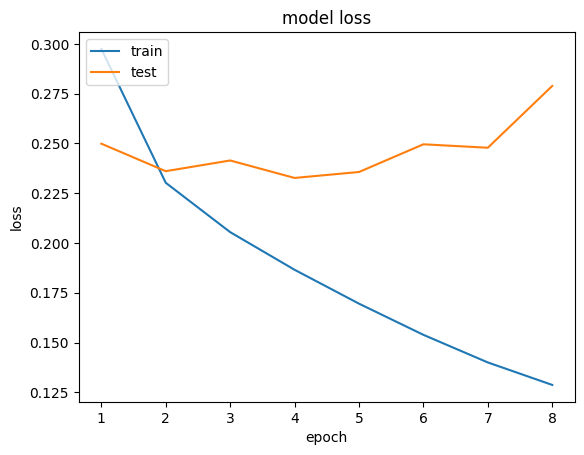

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

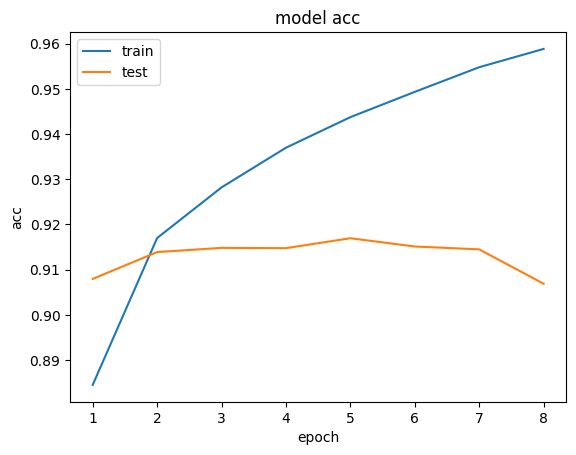

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()